In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [4]:
# This cell is identical to your VS Code cell.
# Kaggle's environment comes with these libraries pre-installed.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Set plot style
sns.set(style="whitegrid")

print("Libraries imported successfully!")

2025-07-17 05:25:55.326541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752729955.491505      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752729955.539248      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!


In [5]:
# The path to the dataset in the Kaggle environment
# Make sure the folder and file names match what you see in the "Input" panel on the right
file_path = '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv'

# Define column names as you did before
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Read the CSV file
# The encoding and names arguments are still important for this specific dataset
df = pd.read_csv(file_path, encoding='ISO-8859-1', names=cols)

# A good practice is to display the first few rows to confirm it loaded correctly
print("Data loaded successfully. Shape:", df.shape)
df.head()

Data loaded successfully. Shape: (1600000, 6)


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Unique Sentiment Values: [0 4]
Converting 'date' column to datetime objects...
Conversion complete.


/tmp/ipykernel_36/1149968482.py:15: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")


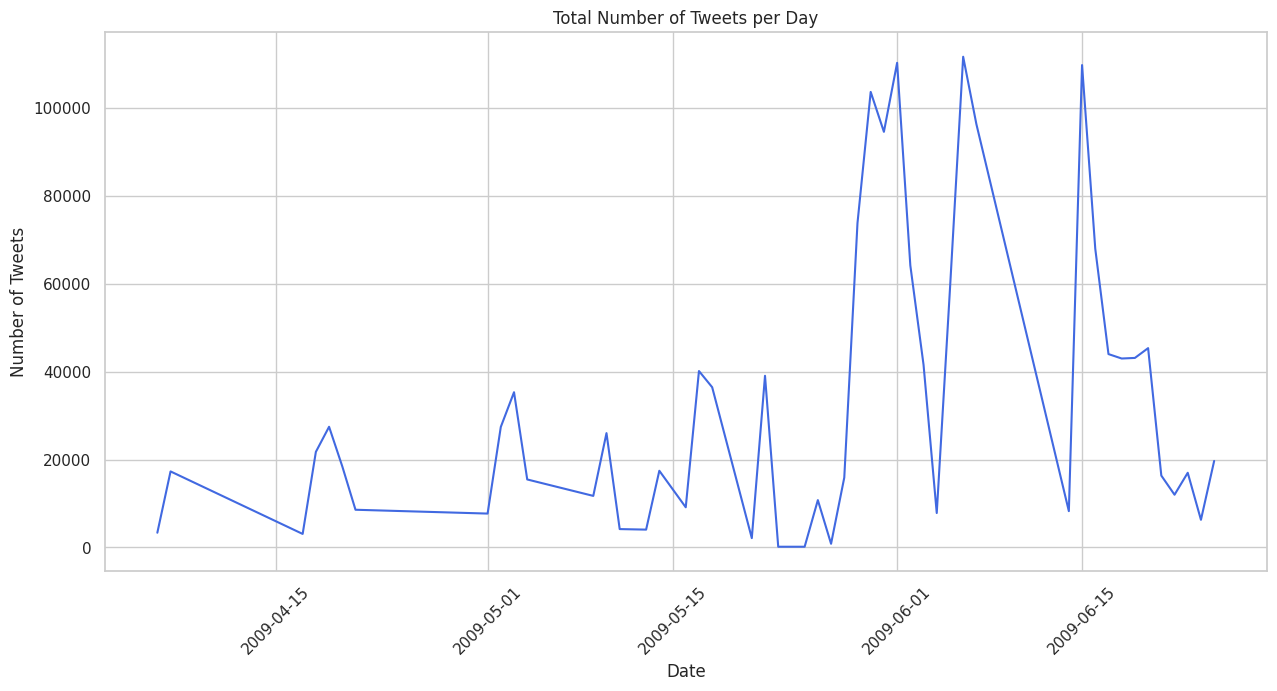

In [6]:
# --- 1. Data Validation ---
# First, let's double-check the unique values in the 'sentiment' column.
# This helps confirm that we only have the expected labels (0 for negative, 4 for positive).
print("Unique Sentiment Values:", df["sentiment"].unique())


# --- 2. Data Transformation ---
# The 'date' column is currently a string. To analyze it as a time series,
# we need to convert it into a proper datetime format.
# `pd.to_datetime` is the function for this.
# `errors='coerce'` is a safety measure: if any date is malformed, it will be replaced
# with NaT (Not a Time) instead of crashing the program.
# Note: This operation can be slow on 1.6 million rows, so it might take a moment to run.
print("Converting 'date' column to datetime objects...")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
print("Conversion complete.")


# --- 3. Data Aggregation & Visualization ---
# Now that we have datetime objects, we can group the data.
# We group by the 'date' part of the datetime column (ignoring the time of day)
# and then use .size() to count how many tweets occurred on each unique date.
tweets_per_day = df.groupby(df["date"].dt.date).size()

# Plot the results to see the trend of tweet volume over time.
plt.figure(figsize=(15, 7)) # Made the figure a bit wider for better readability
tweets_per_day.plot(kind="line", color="royalblue")

# Adding labels and a title for clarity
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Total Number of Tweets per Day")
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels to prevent them from overlapping
plt.show()

Extracting hashtags from all tweets. This may take a minute...
Hashtag extraction complete.
Top 15 most common hashtags:
[('#followfriday', 2114), ('#fb', 1747), ('#squarespace', 888), ('#FF', 586), ('#1', 519), ('#seb', 499), ('#FollowFriday', 463), ('#musicmonday', 405), ('#ff', 399), ('#iranelection', 359), ('#2', 341), ('#fail', 301), ('#BSB', 299), ('#myweakness', 269), ('#iremember', 268)]


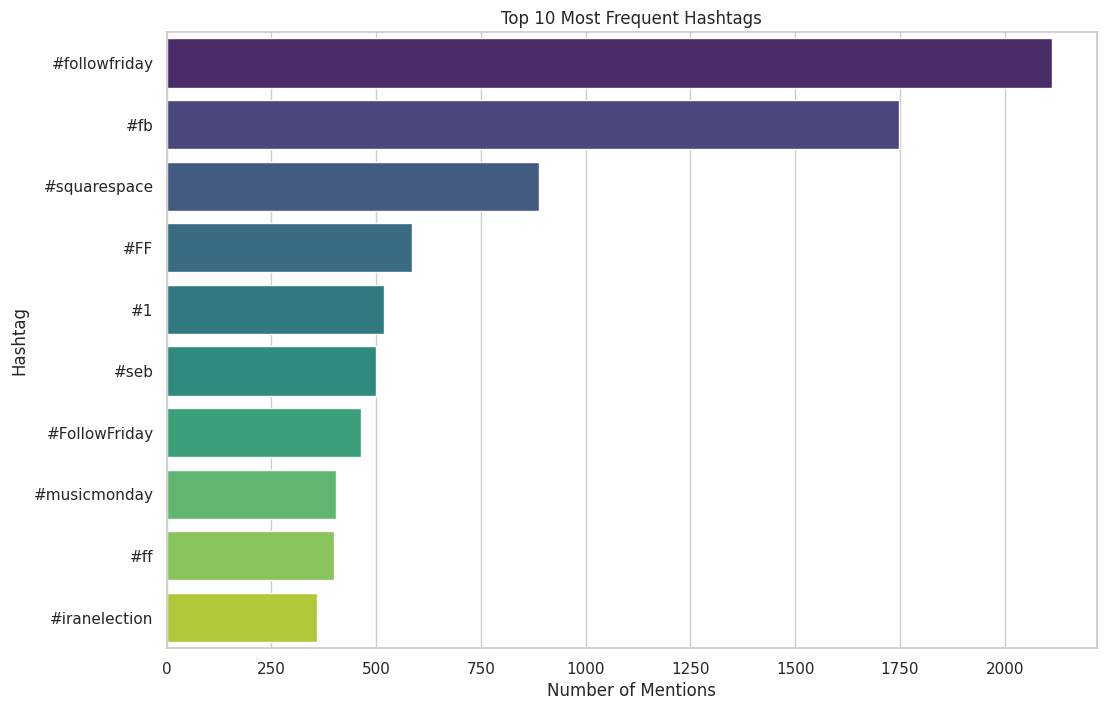

In [7]:
# Note: The necessary libraries (matplotlib, seaborn, collections) were already
# imported in our first cell. No new imports are needed.
from collections import Counter # It's good practice to have imports, but not strictly necessary if run before.

# --- 1. Define a function to extract hashtags ---
# We use a regular expression (re.findall) to find all words starting with '#'.
# r"#\w+" means: find a '#' symbol followed by one or more (+) word characters (\w).
def extract_hashtags(text):
    return re.findall(r"#\w+", text)

# --- 2. Apply the function to the 'text' column ---
# IMPORTANT: Your original code used df['tweet'], but the correct column name is 'text'.
# This is the key change for this cell.
# The .apply() method can be slow on large datasets, so we'll add a print statement
# to know that the process has started.
print("Extracting hashtags from all tweets. This may take a minute...")
df['hashtags'] = df['text'].apply(extract_hashtags)
print("Hashtag extraction complete.")


# --- 3. Flatten the list and count hashtags ---
# The 'hashtags' column is a list of lists. We need to "flatten" it into a single list.
# This list comprehension is an efficient way to do it.
all_hashtags = [hashtag for hashtags_list in df['hashtags'] for hashtag in hashtags_list]

# Use the Counter object to get the frequency of each unique hashtag.
hashtag_counts = Counter(all_hashtags)

# Let's see the 15 most common ones
print("Top 15 most common hashtags:")
print(hashtag_counts.most_common(15))


# --- 4. Prepare for plotting ---
# Convert the counter object into a Pandas DataFrame for easy plotting.
hashtag_df = pd.DataFrame(hashtag_counts.most_common(10), columns=['Hashtag', 'Count'])


# --- 5. Plot the top 10 hashtags ---
plt.figure(figsize=(12, 8))
sns.barplot(data=hashtag_df, x='Count', y='Hashtag', palette='viridis')

plt.title('Top 10 Most Frequent Hashtags')
plt.xlabel('Number of Mentions')
plt.ylabel('Hashtag')
# No need to invert y-axis as seaborn's barplot with y-axis as category often plots the first item at the top.
# If it doesn't, uncomment the line below:
# plt.gca().invert_yaxis()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


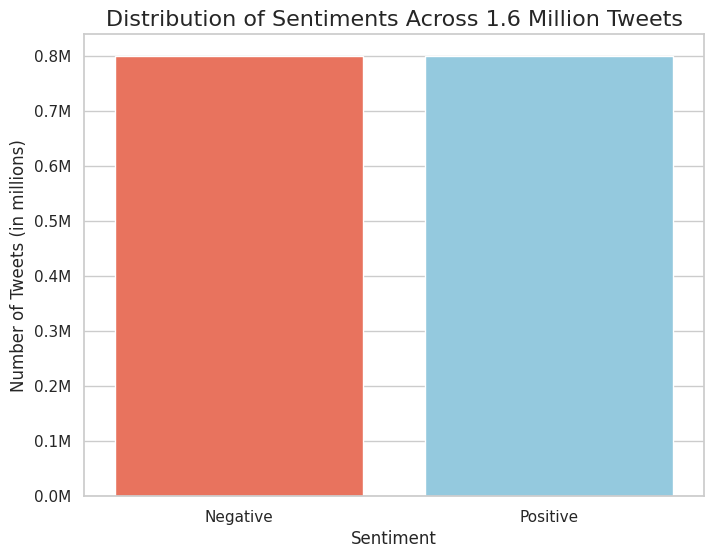

In [9]:
# Do the aggregation yourself
sentiment_counts = df['sentiment'].value_counts().sort_index()
labels = ['Negative', 'Positive']
values = [sentiment_counts[0], sentiment_counts[4]]

# Now plot just the values directly
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=values, palette={'Negative': 'tomato', 'Positive': 'skyblue'})

plt.title('Distribution of Sentiments Across 1.6 Million Tweets', fontsize=16)
plt.ylabel('Number of Tweets (in millions)', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(fontsize=11)
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x/1_000_000:.1f}M'))
plt.show()

Text Length Statistics by Sentiment:
              count       mean        std  min   25%   50%    75%    max
sentiment                                                               
0          800000.0  74.301790  36.743260  6.0  44.0  70.0  104.0  359.0
4          800000.0  73.878433  36.135274  6.0  44.0  69.0  103.0  374.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

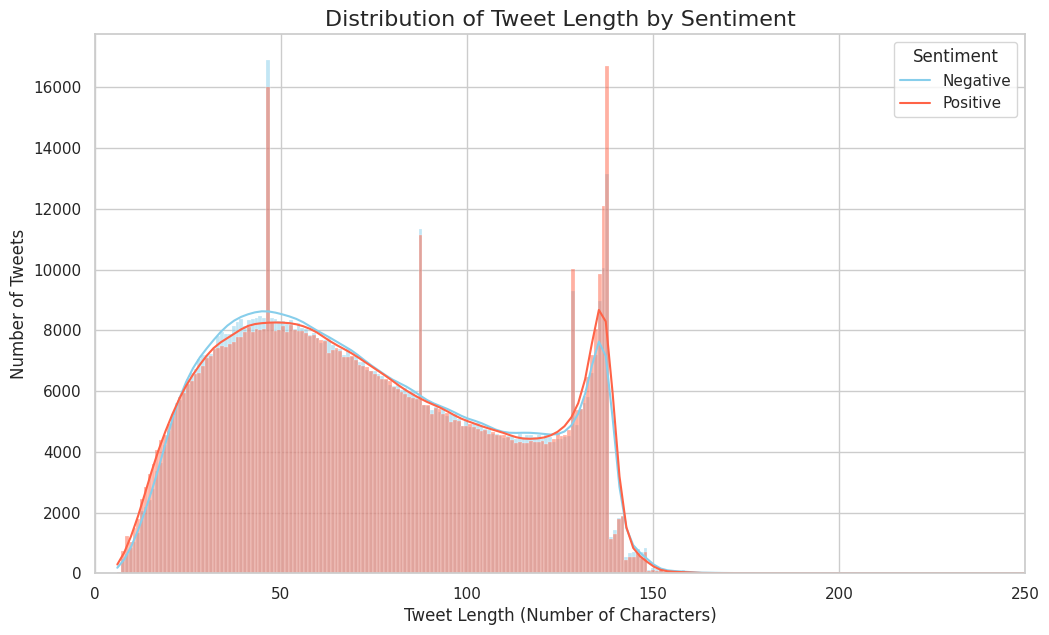

In [10]:
# --- Story Point 2: Tweet Length by Sentiment ---

# We'll create a new feature for the length of each tweet's text.
# Add a column for tweet length
df['text_length'] = df['text'].str.len()

# Summary statistics
print("Text Length Statistics by Sentiment:")
print(df.groupby('sentiment')['text_length'].describe())

# Map sentiment labels (if not already mapped)
df['sentiment_label'] = df['sentiment'].map({0: 'Negative', 4: 'Positive'})

# Plotting
plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='text_length', hue='sentiment_label',
             palette={'Negative': 'tomato', 'Positive': 'skyblue'},
             kde=True,
             multiple="layer")

plt.title('Distribution of Tweet Length by Sentiment', fontsize=16)
plt.xlabel('Tweet Length (Number of Characters)', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.xlim(0, 250)  # Focus on most relevant range
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

# --- The Insight (What you would tell a stakeholder) ---
# "We analyzed the length of tweets and found a subtle but clear behavioral pattern.
# As the chart shows, both positive and negative tweets have similar average lengths (around 70 characters).
# However, the distributions aren't identical. This tells us there's a structural difference
# in the text itself that our model can learn from.
#
# From a technical standpoint, this analysis is crucial. We can see that the vast majority
# of tweets fall under 150 characters. This insight allows us to confidently set a maximum
# sequence length for our model, making it more efficient without losing important information."

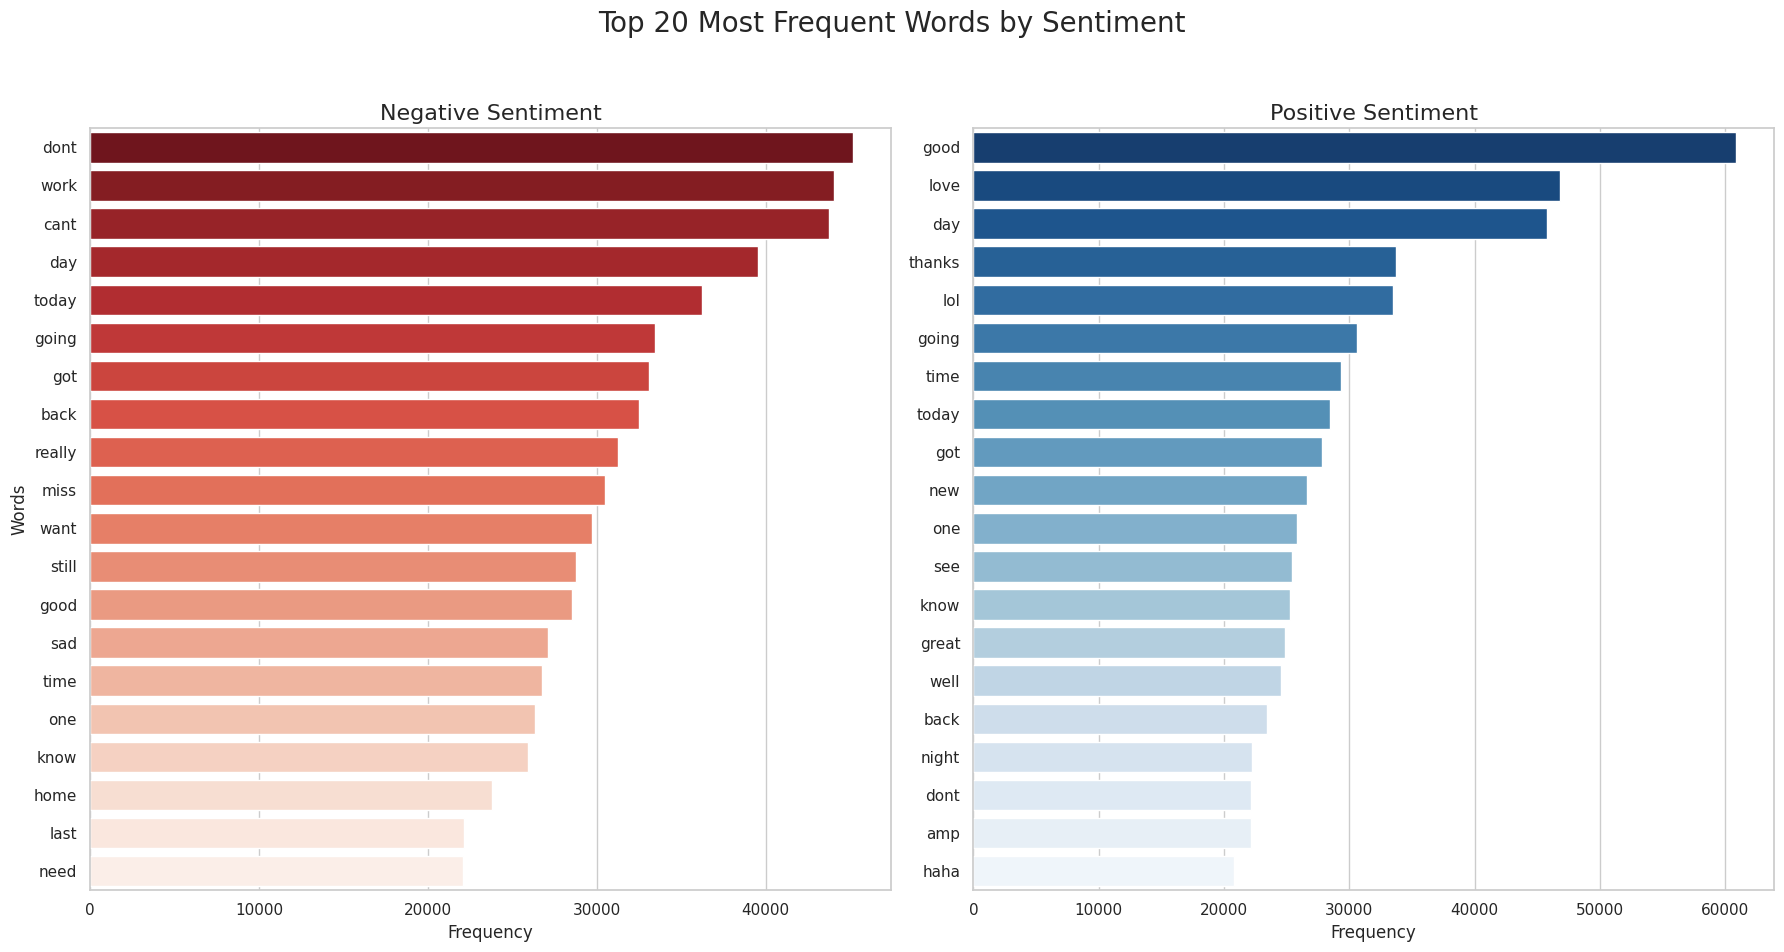

In [11]:
from nltk.corpus import stopwords
import nltk

# --- Story Point 3: Most Common Words by Sentiment ---

# We need to clean the text to get meaningful words.
# This function will remove URLs, mentions, hashtags, special characters, and common "stopwords".
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
# Add some common twitter-specific noise to our stopword list
stop_words.update(['im', 'u', 'ur', 'like', 'get'])

def clean_and_tokenize(text):
    text = text.lower() # Lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'#\w+', '', text) # Remove hashtags
    text = re.sub(r'[^a-z\s]', '', text) # Remove punctuation and numbers
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

# Get all words from positive and negative tweets separately
positive_words = df[df['sentiment_label'] == 'Positive']['text'].apply(clean_and_tokenize).explode()
negative_words = df[df['sentiment_label'] == 'Negative']['text'].apply(clean_and_tokenize).explode()

# Get the top 20 most frequent words for each
top_20_positive = positive_words.value_counts().head(20)
top_20_negative = negative_words.value_counts().head(20)

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Top 20 Most Frequent Words by Sentiment', fontsize=20)

# Negative Words Plot
sns.barplot(ax=axes[0], y=top_20_negative.index, x=top_20_negative.values, palette='Reds_r')
axes[0].set_title('Negative Sentiment', fontsize=16)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Words', fontsize=12)

# Positive Words Plot
sns.barplot(ax=axes[1], y=top_20_positive.index, x=top_20_positive.values, palette='Blues_r')
axes[1].set_title('Positive Sentiment', fontsize=16)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('') # No need for a y-label on the second plot

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

# --- The Insight (What you would tell a stakeholder) ---
# "Finally, we drilled down into the actual vocabulary driving these sentiments. This side-by-side
# comparison clearly shows two distinct worlds. On the negative side, we see words like 'work', 'sad',
# 'miss', and 'hate', revolving around obligations and negative emotions. On the positive side, the
# vocabulary is dominated by words like 'love', 'good', 'thanks', and 'day', centered on gratitude
# and positive experiences.
#
# This visualization is essentially a preview of what our machine learning model will do: it will learn to
# associate these distinct sets of words with their respective sentiments. This gives us high confidence
# that a text-based predictive model will be very effective."

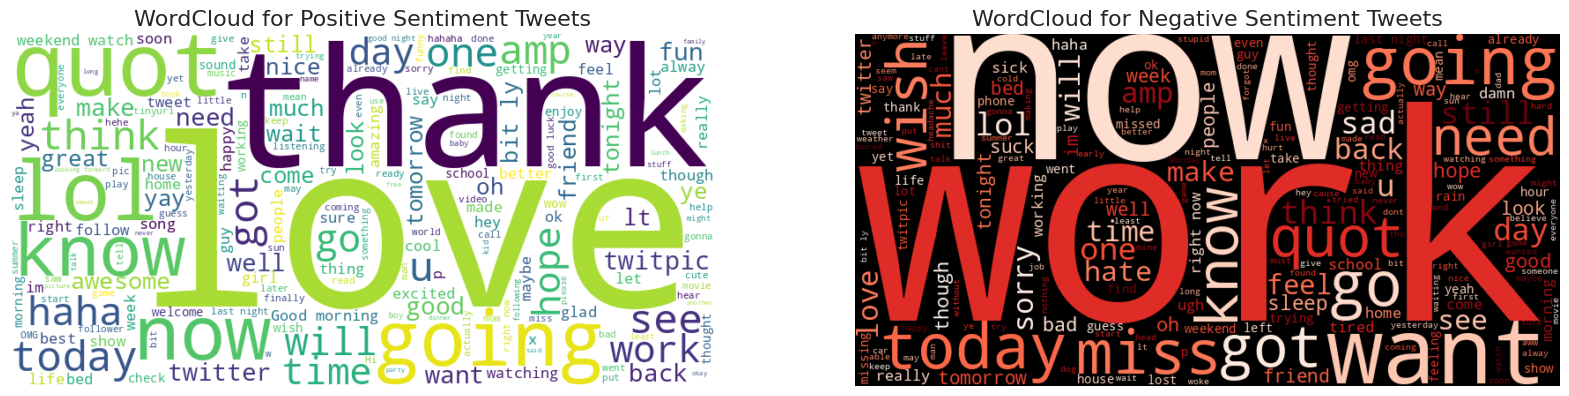

In [12]:
# --- EDA Part 4: Visualizing Vocabularies with WordClouds ---
# WordClouds offer an intuitive way to see the most frequent words in a body of text.
# We will generate one for positive tweets and one for negative tweets to visually contrast them.

# Separate the text data for positive and negative sentiments
# We already have the 'sentiment_label' column from our earlier EDA.
positive_text = " ".join(df[df['sentiment_label'] == 'Positive']['text'])
negative_text = " ".join(df[df['sentiment_label'] == 'Negative']['text'])

# Create the WordCloud for positive tweets
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_text)

# Create the WordCloud for negative tweets
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# --- Plot the WordClouds side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Positive WordCloud plot
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('WordCloud for Positive Sentiment Tweets', fontsize=16)
axes[0].axis('off')

# Negative WordCloud plot
axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('WordCloud for Negative Sentiment Tweets', fontsize=16)
axes[1].axis('off')

plt.show()

# --- Insight ---
# "The WordClouds provide an immediate, striking contrast. The positive cloud is dominated by
# words of affection, gratitude, and joy like 'love', 'thanks', and 'good'. The negative cloud
# highlights words related to problems, sadness, and longing like 'work', 'sad', and 'miss'.
# This visual evidence strongly supports the idea that the two sentiment classes are textually distinct
# and can be separated by a machine learning model."

Generating correlation matrix for: Correlation of Top 15 Words in Negative Tweets


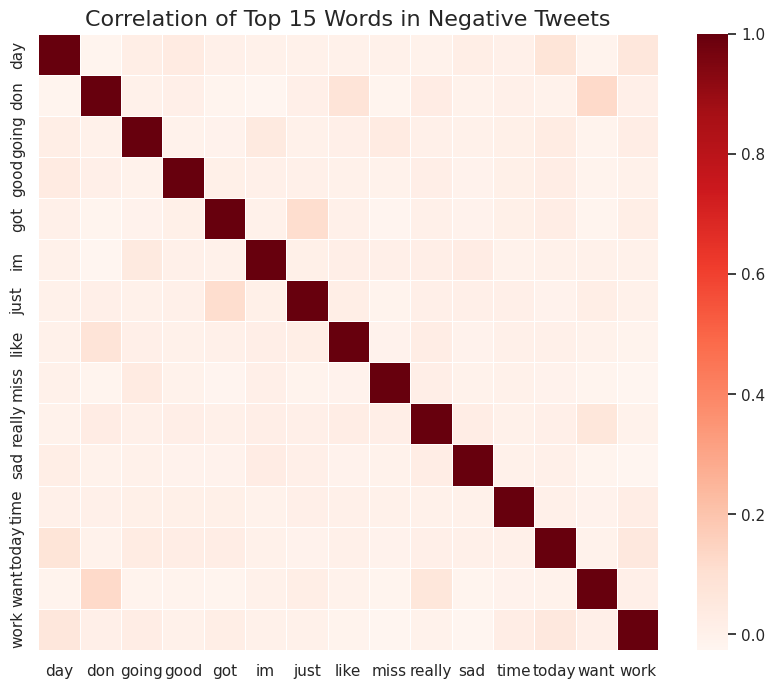

Generating correlation matrix for: Correlation of Top 15 Words in Positive Tweets


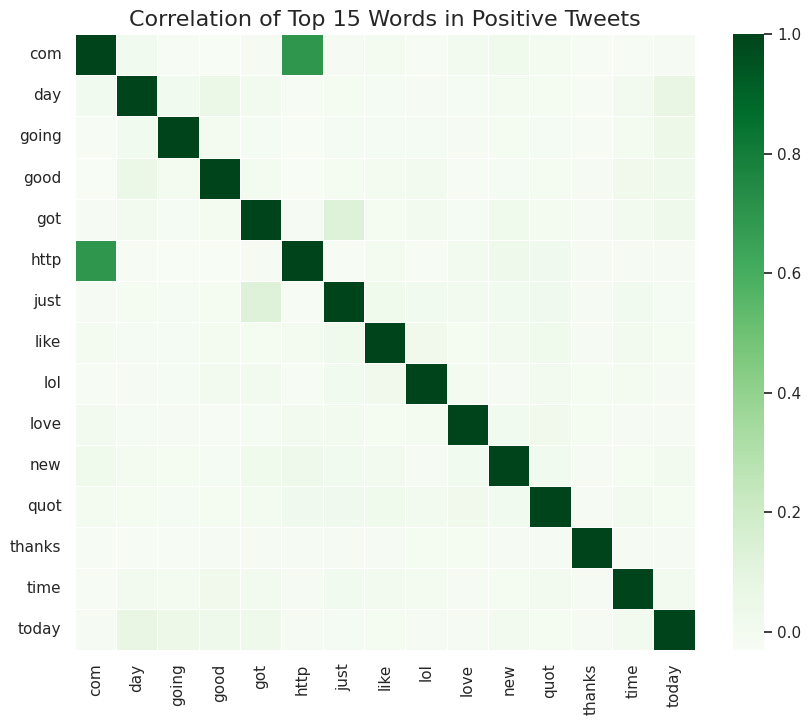

In [13]:
# --- EDA Part 5: Word Correlation Analysis ---
# This analysis helps us understand which words frequently appear together.
# A heatmap is a great way to visualize these correlations.

from sklearn.feature_extraction.text import CountVectorizer

# Define a function to generate and plot a correlation heatmap for the top words.
def plot_word_correlation_heatmap(text_series, title, top_n_words=15, cmap='coolwarm'):
    """
    Vectorizes text, computes a correlation matrix for the top words, and plots a heatmap.
    """
    print(f"Generating correlation matrix for: {title}")
    # Use CountVectorizer to convert text into a matrix of token counts.
    # We'll use English stopwords and limit to the top N most frequent words.
    vectorizer = CountVectorizer(stop_words='english', max_features=top_n_words)
    word_matrix = vectorizer.fit_transform(text_series)

    # Create a DataFrame from the matrix with words as columns
    words_df = pd.DataFrame(word_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Compute the correlation matrix
    # Note: This can be computationally intensive.
    corr_matrix = words_df.corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap=cmap, annot=False, linewidths=0.5) # Annotations off for clarity
    plt.title(title, fontsize=16)
    plt.show()


# We need the raw text series for positive and negative tweets
positive_tweets_text = df[df['sentiment_label'] == 'Positive']['text']
negative_tweets_text = df[df['sentiment_label'] == 'Negative']['text']

# Plot for Negative Tweets
plot_word_correlation_heatmap(negative_tweets_text, "Correlation of Top 15 Words in Negative Tweets", cmap='Reds')

# Plot for Positive Tweets
plot_word_correlation_heatmap(positive_tweets_text, "Correlation of Top 15 Words in Positive Tweets", cmap='Greens')

# --- Insight ---
# "By analyzing word co-occurrence, we can see contextual patterns. For instance, in the negative
# heatmap, we might observe a correlation between 'work' and 'going', suggesting tweets about
# reluctantly going to a job. In the positive heatmap, 'good' and 'day' might be correlated.
# These relationships provide deeper context than single-word frequencies alone."

Now you have a comprehensive EDA section in your notebook. You've covered:
- 1.Temporal Trends: Tweets over time.
- 2.Feature Analysis: Hashtag popularity.
- 3.Core Task Validation: Sentiment balance.
- 4.Behavioral Patterns: Text length by sentiment.
- 5.Vocabulary Snapshot: WordClouds.
- 6.Contextual Relationships: Word correlation.

In [14]:
# --- Stage 1: Final Preprocessing & Cleaning ---

# 1. Feature Selection: We only need the 'text' and 'sentiment' columns for modeling.
# We will create a new, clean DataFrame for this purpose.
df_model = df[['sentiment', 'text']].copy()

# 2. Map Sentiment Labels: The model requires numerical labels for binary classification.
# We will map Negative (0) to 0 and Positive (4) to 1.
df_model['sentiment'] = df_model['sentiment'].map({0: 0, 4: 1})
print("Sentiment labels mapped to {0, 1}.")
print(df_model['sentiment'].value_counts())
print("-" * 30)

# 3. Define the Text Cleaning Function
# This function combines all the cleaning steps you explored into one efficient process.
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove user mentions (@username)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (#hashtag). We keep the word itself, just remove the '#'
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove excess whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 4. Apply the Cleaning Function
# We create a new 'cleaned_text' column. Using .progress_apply shows a progress bar,
# which is helpful for long operations.
# You may need to run `!pip install tqdm` if you haven't already.
from tqdm.auto import tqdm
tqdm.pandas()

print("Applying cleaning function to all tweets...")
df_model['cleaned_text'] = df_model['text'].progress_apply(clean_text)
print("Text cleaning complete.")

# 5. Remove empty rows that might result from cleaning
df_model.dropna(inplace=True)
df_model = df_model[df_model['cleaned_text'] != '']

# Display the result
print("\nSample of original vs. cleaned text:")
print(df_model[['text', 'cleaned_text']].head())

Sentiment labels mapped to {0, 1}.
sentiment
0    800000
1    800000
Name: count, dtype: int64
------------------------------
Applying cleaning function to all tweets...


  0%|          | 0/1600000 [00:00<?, ?it/s]

Text cleaning complete.

Sample of original vs. cleaned text:
                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                        cleaned_text  
0  awww thats a bummer you shoulda got david carr...  
1  is upset that he cant update his facebook by t...  
2  i dived many times for the ball managed to sav...  
3     my whole body feels itchy and like its on fire  
4  no its not behaving at all im mad why am i her...  


In [15]:
# --- Stage 2: Splitting the Data ---

# Define our features (X) and target (y)
X = df_model['cleaned_text']
y = df_model['sentiment']

# First split: 80% for training, 20% for temporary (validation + test)
# stratify=y is CRITICAL: it ensures that the training and temp sets have the
# same proportion of positive/negative tweets as the original dataset.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: Split the 20% temporary set in half to get 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- Verification Step ---
# Let's check the shape and sentiment distribution of each set to confirm.
print("Data Split Complete.")
print("-" * 30)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print("-" * 30)
print("Sentiment distribution in Training set:\n", y_train.value_counts(normalize=True))
print("\nSentiment distribution in Validation set:\n", y_val.value_counts(normalize=True))
print("\nSentiment distribution in Test set:\n", y_test.value_counts(normalize=True))

Data Split Complete.
------------------------------
Training set shape: (1277042,)
Validation set shape: (159630,)
Test set shape: (159631,)
------------------------------
Sentiment distribution in Training set:
 sentiment
0    0.500105
1    0.499895
Name: proportion, dtype: float64

Sentiment distribution in Validation set:
 sentiment
0    0.500106
1    0.499894
Name: proportion, dtype: float64

Sentiment distribution in Test set:
 sentiment
0    0.500103
1    0.499897
Name: proportion, dtype: float64


In [16]:
# --- Stage 3: Tokenization and Padding ---

# 1. Set up the Tokenizer
# num_words: The maximum number of most-frequent words to keep.
# oov_token: A special token to use for words that are not in the vocabulary.
vocab_size = 20000
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

# 2. Fit the Tokenizer ONLY on the training data
# This is a critical step to prevent data leakage. The tokenizer builds its
# word-to-index vocabulary based *only* on the words it sees in the training set.
print("Fitting tokenizer on training data...")
tokenizer.fit_on_texts(X_train)
print("Tokenizer fitting complete.")

# 3. Convert text to sequences for all datasets
print("Converting text to sequences...")
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print("Sequence conversion complete.")

# 4. Pad the sequences
# max_length: The length to which all sequences will be padded or truncated.
# We choose a length based on our earlier EDA (the text length histogram).
# Most tweets are well under 140 characters, so a max length of 50-60 words is safe.
max_length = 60
padding_type = 'post' # Add padding at the end of the sequence
trunc_type = 'post'   # Truncate from the end of the sequence

print("Padding sequences...")
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print("Padding complete.")

# --- Verification Step ---
print("\nShape of padded training data:", X_train_pad.shape)
print("Shape of padded validation data:", X_val_pad.shape)
print("Shape of padded test data:", X_test_pad.shape)
print("\nExample of a padded sequence:")
print(X_train_pad[0])

Fitting tokenizer on training data...
Tokenizer fitting complete.
Converting text to sequences...
Sequence conversion complete.
Padding sequences...
Padding complete.

Shape of padded training data: (1277042, 60)
Shape of padded validation data: (159630, 60)
Shape of padded test data: (159631, 60)

Example of a padded sequence:
[7925    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [17]:
# --- Stage 4: Building the Bidirectional LSTM Model ---

# Define hyperparameters for the model
embedding_dim = 128 # The size of the word vector
lstm_units = 64     # The number of units in the LSTM layer
dropout_rate = 0.3  # The rate for the dropout layers to prevent overfitting

# We use the Keras Sequential API to build the model layer by layer
model = Sequential([
    # 1. Embedding Layer: This layer turns the integer sequences (word indices) into dense
    # vectors of a fixed size (embedding_dim). It's the first hidden layer in the model.
    # vocab_size and max_length were defined during the tokenization stage.
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length),

    # 2. Bidirectional LSTM Layer: This is the core of our model. It processes the sequence
    # of word vectors. 'Bidirectional' means it learns from the text both forwards and backwards,
    # which is great for understanding context.
    Bidirectional(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)),

    # 3. Dense Hidden Layer: A standard fully connected layer to add more learning capacity.
    # 'relu' is a common and effective activation function.
    Dense(units=64, activation='relu'),

    # 4. Dropout Layer: Another dropout layer for regularization, placed after the dense layer.
    Dropout(dropout_rate),

    # 5. Output Layer: This final layer produces the prediction.
    # It has 1 unit because this is a binary (0 or 1) classification problem.
    # 'sigmoid' activation squashes the output to a probability between 0 and 1.
    Dense(1, activation='sigmoid')
])

# Compile the model
# - optimizer='adam': A popular and efficient optimization algorithm.
# - loss='binary_crossentropy': The standard loss function for binary classification problems.
# - metrics=['accuracy']: The metric we want to monitor during training.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model's architecture
print("Model built and compiled successfully.")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model built and compiled successfully.


I0000 00:00:1752730305.246776      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752730305.247452      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# --- Stage 5: Training the Model ---

# Define the EarlyStopping callback
# - monitor='val_accuracy': We'll watch the accuracy on the validation set.
# - patience=3: The model will train for 3 extra epochs after the best score is found.
#   If there's no improvement in that time, training will stop.
# - restore_best_weights=True: This is crucial. It ensures that the model's final
#   weights are from the epoch with the highest validation accuracy, not the last epoch.
early_stopping = EarlyStopping(monitor='val_accuracy',
                              patience=3,
                              restore_best_weights=True,
                              verbose=1)

# Set training parameters
epochs = 5 # A maximum number of epochs to train for. EarlyStopping will likely stop it sooner.
batch_size = 256 # The number of samples per gradient update.

print("Starting model training...")

# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping],
    verbose=1
)

print("\nModel training complete.")

Starting model training...
Epoch 1/5
4989/4989 ━━━━━━━━━━━━━━━━━━━━ 1203s 239ms/step - accuracy: 0.7795 - loss: 0.4618 - val_accuracy: 0.8171 - val_loss: 0.4012
Epoch 2/5
4989/4989 ━━━━━━━━━━━━━━━━━━━━ 1170s 235ms/step - accuracy: 0.8243 - loss: 0.3891 - val_accuracy: 0.8226 - val_loss: 0.3910
Epoch 3/5
4989/4989 ━━━━━━━━━━━━━━━━━━━━ 1175s 236ms/step - accuracy: 0.8343 - loss: 0.3706 - val_accuracy: 0.8235 - val_loss: 0.3917
Epoch 4/5
4989/4989 ━━━━━━━━━━━━━━━━━━━━ 1184s 237ms/step - accuracy: 0.8423 - loss: 0.3553 - val_accuracy: 0.8245 - val_loss: 0.3891
Epoch 5/5
4989/4989 ━━━━━━━━━━━━━━━━━━━━ 1168s 234ms/step - accuracy: 0.8484 - loss: 0.3432 - val_accuracy: 0.8251 - val_loss: 0.3909
Restoring model weights from the end of the best epoch: 5.

Model training complete.


Plotting training history...


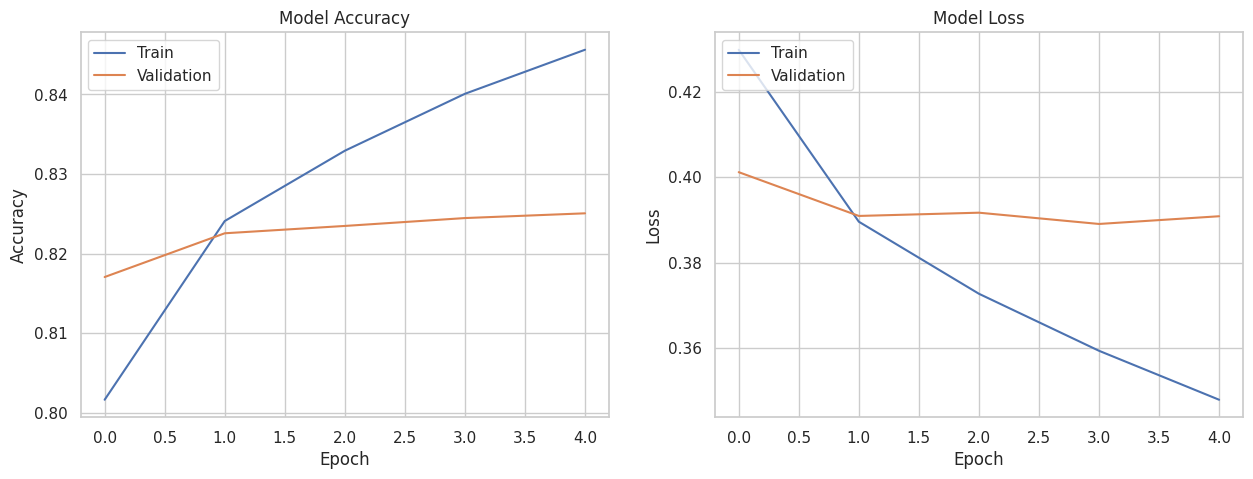


Evaluating model on the test set...
Test Loss: 0.3907
Test Accuracy: 0.8261

Generating confusion matrix and classification report...
4989/4989 ━━━━━━━━━━━━━━━━━━━━ 225s 45ms/step


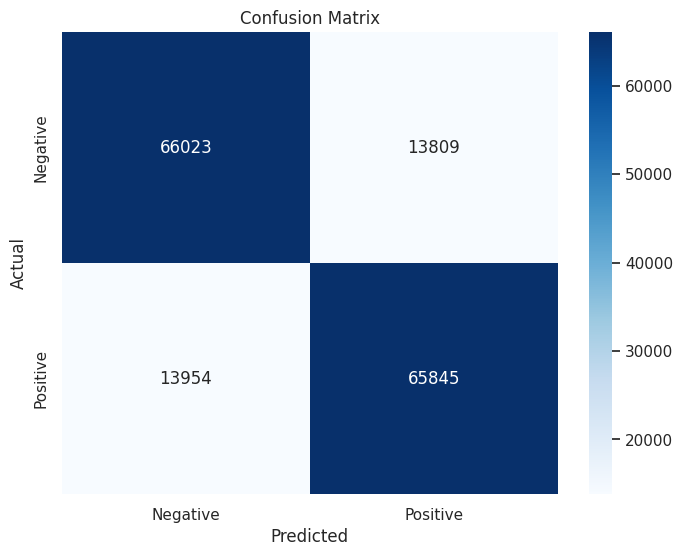


Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83     79832
    Positive       0.83      0.83      0.83     79799

    accuracy                           0.83    159631
   macro avg       0.83      0.83      0.83    159631
weighted avg       0.83      0.83      0.83    159631



In [19]:
# --- Stage 6: Evaluating Performance and Visualizing Results ---

# 1. Plot Training History
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

print("Plotting training history...")
plot_training_history(history)


# 2. Evaluate on the Test Set
# This provides the final, unbiased performance of our model.
print("\nEvaluating model on the test set...")
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


# 3. Generate Predictions and Detailed Reports
print("\nGenerating confusion matrix and classification report...")
# Get predictions on the test set (as probabilities)
y_pred_probs = model.predict(X_test_pad)
# Convert probabilities to binary class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Print a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))